## Sobel Operator 

### Motivation 

We saw previously that an image filter (also called kernel) takes an image and apply a transformation to it. The kernels that have been analyzed were associated to the gaussian blur and the mean blur. The kernel that will be apply here is a kernel that is useful for edge detection Edge detection is trying to find the regions in an image where there is a sharp change of intensity or a sharp change in color. A common operator used for this is the sobel operator. The purpose here is to take a black and white image (if it is a colored image, we simply convert it) and returns another image with highlights around the edges of the original image (see the following image).

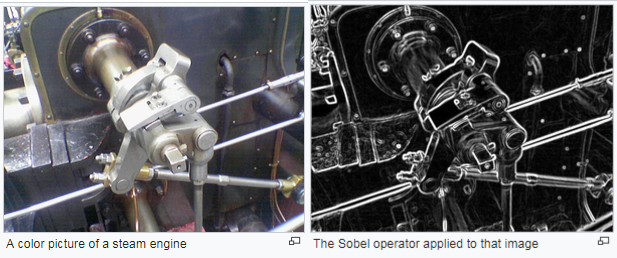

In [4]:
from IPython.display import Image
# Source: https://en.wikipedia.org/wiki/Sobel_operator
Image(r'before_after.png', width=500, height=500)

### Sobel Operator 

#### Understanding the Kernel Matrix

An important idea linked to sobel operator is to build an approximation of the derivative of an image. The way to proceed is by creating two kernel matrices: one for the horizontal axis (x axis) and the other for the vertical axis (y axis):
$$
\mathbf{G}_{x} = 
\begin{bmatrix}
    -1 & 0 & 1  \\
    -2 & 0 & 2  \\
    -1 & 0 & 1 
\end{bmatrix}, \quad
\mathbf{G}_{y} = 
\begin{bmatrix}
   -1 & -2 & -1  \\
    0 & 0 & 0  \\
    1 & 2 & 1 
\end{bmatrix}
$$

An interesting fact is that the sobel filter includes a Gaussian filter. The $2$s in the filter kernel are not meant to preserve pixels in the centre. Their purpose is to smooth the image and reduce the noise in the output. Thus, the sobel filter in x-direction and in the y-direction include a gaussian filter. The sobel filter can be considered as combination of the Prewitt filter and Gaussian filter. For those unfamiliar with Prewitt filter, it is basically like sobel filter, but with the weights inspired from mean blur instead of gaussian blur. Here are the Prewitt filters for each axis:
$$
\mathbf{G}_{x} = 
\begin{bmatrix}
    -1 & 0 & 1  \\
    -1 & 0 & 1  \\
    -1 & 0 & 1 
\end{bmatrix}, \quad
\mathbf{G}_{y} = 
\begin{bmatrix}
   -1 & -1 & -1  \\
    0 & 0 & 0  \\
    1 & 1 & 1 
\end{bmatrix}
$$

Now, let's focus on the idea behind these kernels. Let's consider a pixel on an image and the filters $\mathbf{G}_{x}$ and $\mathbf{G}_{y}$. By checking $\mathbf{G}_{x}$, one can see that the idea is to substract the left neighborhood of the pixel from the right neighborhood of the pixel. If there is a vertical change in color, applying $\mathbf{G}_{x}$ to the pixel and its neighorhood should give value far from zero. In a similar way, by checking $\mathbf{G}_{y}$, one can see that the idea is to substract the upper neighborhood of the pixel from the lower neighborhood of the pixel. If there is an horizontal change in color, applying $\mathbf{G}_{y}$ to the pixel and its neighorhood should give value far from zero.

#### Edges Detection on an Image

Now that we found the kernel matrices, we need to find a way to create detect the edges of our image. A simple idea would be to build a black and white image with the results of our filters. Unfortunalety, this is not possible because of two problems. First, after applying the sobel filter on each pixel of the image, we obtain values that are not in our integers range (which is $0,1,2,...,255$). Secondly, there are two matrices of values and the purpose is to represent them into one image.

The solution that is generally used is the following. For each point of the original image, we create a single representation by combining the gradients with Pythagorean theorem $\mathbf{G} = \sqrt{\mathbf{G}_{x}+\mathbf{G}_{y}}$. By doing this, the second problem is solved and the first problem is partly solve (no more negative values). To obtain values in our range of integers, all we have to do is to rescale our values (for every value: add absolute value of minimum, divide by the current maximum, multiply by 255 and round to nearest integer).

#### Writing the Functions

In [62]:
def sobel_filter_y():
    """
    Create a 3x3 matrix kernel for the sobel filter (y axis).
    """
    row1 = np.array([-1,-2,-1])
    row2 = np.array([0,0,0])
    row3 = np.array([1,2,1])
    return np.stack((row1, row2, row3))

In [63]:
def sobel_filter_x():
    """
    Create a 3x3 matrix kernel for the sobel filter (x axis).
    """
    y_filter = sobel_filter_y()
    return y_filter.transpose()

In [146]:
def image_edge_detect(image,kernel):
    """
    Detect the edges of an image with a given kernel.
    image: Image.
    kernel: Sobel filter.
    """
    kernel_size = kernel.shape[0]
    
    # Envelop the image with zeroes
    corrected_image = zeroes_matrix_container(image,kernel_size)
    new_image = np.empty([corrected_image.shape[0], corrected_image.shape[1]])
    
    nb_rows = corrected_image.shape[0]
    nb_columns = corrected_image.shape[1]
    nb_zeroes_line = int((kernel_size-1)/2)
    nb_zeroes_columns = int((kernel_size-1)/2)
    
    # Apply the filter transformation on every pixel of the original image
    for i in range(nb_zeroes_line,nb_rows-1-nb_zeroes_line):
        for j in range(nb_zeroes_line,nb_columns-1-nb_zeroes_columns):
            new_image[i,j] = pixel_edge_detect(corrected_image[(i-(nb_zeroes_line)):(i+(nb_zeroes_line)+1),(j-(nb_zeroes_columns)):(j+(nb_zeroes_columns)+1)], kernel)
            
    return new_image[(nb_zeroes_line):(nb_rows-1-nb_zeroes_line),(nb_zeroes_line):(nb_columns-1-nb_zeroes_columns)]

In [65]:
def pixel_edge_detect(pixel, kernel):
    """
    Multiply a pixel and its neighborhood by a kernel.
    pixel: A pixel and its neighbours.
    kernel: Sobel filter.
    """
    matrix_multi = np.multiply(pixel, kernel)
    return matrix_multi.sum()

In [172]:
def zeroes_matrix_container(image,kernel_size):
    """
    Create a sparse matrix (only zeroes) that will contains the image.
    image: Image to envelop of zeroes.
    kernel_size: Number of rows (or columns) in the sobel filter. 
    Source: sangrey (https://stackoverflow.com/questions/40833073/insert-matrix-into-the-center-of-another-matrix-in-python)
    """
    image_nb_rows = image.shape[0]
    image_nb_columns = image.shape[1]
    
    zeroes_matrix = np.zeros((image_nb_rows+kernel_size-1,image_nb_columns+kernel_size-1))
    
    n_zeroes_lines = zeroes_matrix.shape[0]
    n_image_lines = image.shape[0]
    lower = (n_zeroes_lines) // 2 - (n_image_lines // 2)
    upper = (n_zeroes_lines // 2) + (n_image_lines // 2) + 1 if image_nb_rows%2!=0 else (n_zeroes_lines // 2) + (n_image_lines // 2) 
    
    n_zeroes_columns = zeroes_matrix.shape[1]
    n_image_columns = image.shape[1]
    left = (n_zeroes_columns) // 2 - (n_image_columns // 2)
    right =  (n_zeroes_columns // 2) + (n_image_columns // 2) + 1 if image_nb_columns%2!=0 else (n_zeroes_columns // 2) + (n_image_columns // 2)
    
    zeroes_matrix[lower:upper, left:right] = image
    return zeroes_matrix

In [74]:
def sobel_operations(image):
    """
    Find the gradient_x matrix and the gradient_y matrix.
    image: Image
    """
    sobel_filters = [sobel_filter_x(), sobel_filter_y()]
    sobel_results = [] 
    for sobel_filter in sobel_filters:
        sobel_results.append(image_edge_detect(image,sobel_filter))
    return sobel_results[0],sobel_results[1]

In [109]:
def rescale_gradient_matrix(gradient_matrix):
    """
    Rescale the gradient matrix.
    gradient_matrix: Gradient matrix.
    """
    minimum = gradient_matrix.min()
    maximum = gradient_matrix.max()
    
    # Scale the matrix to be [0,1]
    corrected_gradient = (gradient_matrix+abs(minimum))/(maximum+abs(minimum))
    
    # Scale the matrix to be in terms of integer
    corrected_gradient = np.ceil(255*corrected_gradient)
    
    return corrected_gradient

In [115]:
def combine_gradients(gradient_matrix_x, gradient_matrix_y):
    """
    Combine the gradient_x and the gradient_y.
    gradient_matrix_x: Matrix of the gradient_x.
    gradient_matrix_y: Matrix of the gradient_y.
    """
    gradient_matrix = np.sqrt(gradient_matrix_x**2 + gradient_matrix_y**2)
    return rescale_gradient_matrix(gradient_matrix)

In [257]:
def gradient_angle(gradient_x, gradient_y):
    """
    Find the angle associate with the gradient.
    gradient_matrix_x: Matrix of the gradient_x.
    gradient_matrix_y: Matrix of the gradient_y.
    """
    mask_inf = 1*((gradient_x==0) & (np.sign(gradient_y) == np.sign(gradient_x)))
    mask_minus_inf = -1* ((gradient_x==0) & (np.sign(gradient_y) != np.sign(gradient_x)))
    mask = mask_inf + mask_minus_inf
    inf_matrix = np.where(mask_inf, math.inf, 0)
    minus_inf_matrix = np.where(mask_minus_inf, -math.inf, 0)
    
    arctan_argument = np.where(gradient_x!=0, gradient_y/gradient_x, 0)
    corrected_arctan_argument = arctan_argument + inf_matrix + minus_inf_matrix
    return np.arctan(corrected_arctan_argument)

In [137]:
def plot_edge_detection(image):
    """
    Plot a set of images of the gradient (and its components).
    image: Image.
    """
    gradient_x, gradient_y = sobel_operations(image)
    scaled_gradient_x = rescale_gradient_matrix(gradient_x)
    scaled_gradient_y = rescale_gradient_matrix(gradient_y)
    scaled_gradient = combine_gradients(gradient_x, gradient_y)
    
    fig, axs = plt.subplots(1, 4,figsize=(15,15))
    fig.subplots_adjust(wspace=0, hspace=0)
    axs[0].imshow(image,cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].set_xticklabels([])
    axs[0].set_yticklabels([])

    axs[1].imshow(scaled_gradient_x,cmap='gray')
    axs[1].set_title('Horizontal Gradient ($\mathbf{G}_{x}$)')
    axs[1].set_xticklabels([])
    axs[1].set_yticklabels([])
    
    axs[2].imshow(scaled_gradient_y,cmap='gray')
    axs[2].set_title('Vertical Gradient ($\mathbf{G}_{y}$)')
    axs[2].set_xticklabels([])
    axs[2].set_yticklabels([])
    
    axs[3].imshow(scaled_gradient,cmap='gray')
    axs[3].set_title('Gradient ($\mathbf{G}$)')
    axs[3].set_xticklabels([])
    axs[3].set_yticklabels([])

### Examples  

In [178]:
# Import packages
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
from functools import partial
import math
from IPython.display import Image

# Import the image to resize
steam_engine = io.imread(r'steam_engine_original.png')[:,:,1]
lena = io.imread(r'lena.png')[:,:,1]
boats = io.imread(r'boats.jpg')[:,:,1]

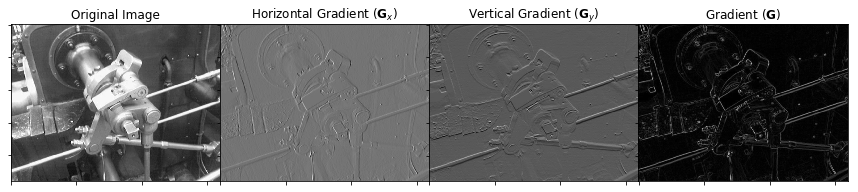

In [175]:
plot_edge_detection(steam_engine)

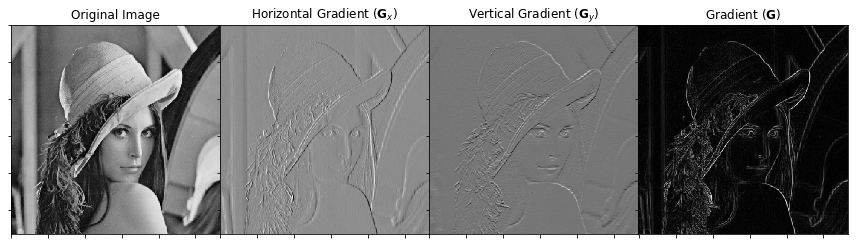

In [174]:
plot_edge_detection(lena)

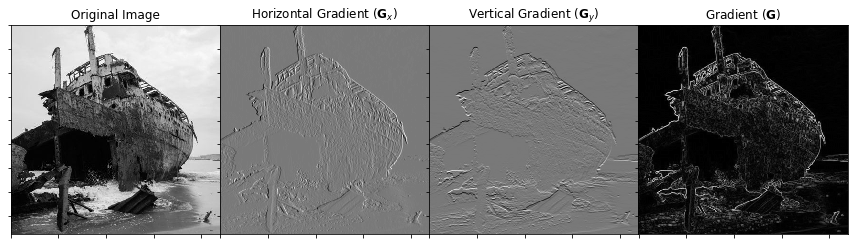

In [177]:
plot_edge_detection(boats)